# Explainer Notebook

## 1. Motivation

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

## 2. Basic stats. Let's understand the dataset better

* Write about your choices in data cleaning and preprocessing
* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In [ ]:
# Installing packages
!pip install openpyxl

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import time
import seaborn as sns
sns.set()
from shapely.geometry import Point
import geopandas
from shapely import wkt
import matplotlib.dates as md
import json
import requests
import geopandas as gpd
from folium.plugins import HeatMap

In this project, we are working with three main datasets:
1. A pre-processed dataset from OpenData [ref]
2. The original dataset from of the pre-processed dataset, containing the specific times that measurements were taken
3. A weather dataset from DMI.

### 2.1 The preprocessed dataset

Although we are working with a dataset that has already been preprocessed, we have to process it further, as we only need some of the columns and most column names are written in Danish. We start by looking at the columns and rows of the dataset:

In [ ]:
# Data preparation
df_tt = pd.read_csv('data/trafiktaelling.csv')
df_tt = df_tt.drop(['FID'], axis=1)

count_row = df_tt.shape[0]
count_col = df_tt.shape[1]

print(f'The dataset consists of {count_row} rows and {count_col} columns')

print('The columns are:')
df_tt.info(memory_usage="deep")

The dataset consists of 1077 rows and 35 columns
The columns are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   t_nr                1077 non-null   int64  
 1   vejnavn             1077 non-null   object 
 2   beskrivelse         923 non-null    object 
 3   husnummer           760 non-null    object 
 4   type                1076 non-null   float64
 5   taelling_type       1077 non-null   object 
 6   ktj_7_19            538 non-null    float64
 7   tung_pct            496 non-null    object 
 8   aadt_koretojer      538 non-null    float64
 9   hvdt_koretojer      538 non-null    float64
 10  cykler_7_19         605 non-null    float64
 11  ladcykler_pct       333 non-null    object 
 12  aadt_cykler         605 non-null    float64
 13  hvdt_cykler         605 non-null    float64
 14  fod_7_19            332 non-null    fl

The dates (`taelle_dato`) are transformed into datetime objects. Sometimes, datasets are not complete in terms of years, i.e. they do not always span an entire year. This could be the case of our dataset, so we inspect the number of observations for each year:

In [ ]:
# Transform into datetime
df_tt['date'] = pd.to_datetime(df_tt.taelle_dato, format="%Y%m%d")
df_tt['date'].dt.year.value_counts().sort_values(ascending=False)

2015    182
2016    163
2019    162
2014    120
2018     89
2017     75
2013     68
2011     63
2012     60
2010     45
2009     44
2020      6
Name: date, dtype: int64

Since we only have 6 observations for 2020, which could be due to the Covid-19 lockdowns, we filter out values from 2020. 

By further inspection of the `wkb_geometry` column, we see that they are `POINT(...)` objects of the longitude and latitude of our observations, wrapped in a string. We convert them into geometry objects for us to extract the longitude and latitude.

In [ ]:
# Filter out values from 2019 and 2020
df_tt = df_tt[df_tt.date.dt.year < 2019]

# Convert into geometry objects
df_tt['wkb_geometry'] = geopandas.GeoSeries.from_wkt(df_tt['wkb_geometry'])

# Remove nans
df_tt = df_tt[~df_tt.wkb_geometry.isna()]

# Extract lon and lat for plotting
df_tt['lon'] = df_tt.wkb_geometry.apply(lambda p: p.x)
df_tt['lat'] = df_tt.wkb_geometry.apply(lambda p: p.y)

We also remove unnecessary columns, so that we keep the following:

1. `t_nr`: a specific ID for the counting (will be used later)
2. `ktj_7_19`: number of cars
3. `cykler_7_19`: number of bikes
4. `fod_7_19`: number of pedestrians
5. `lastbiler_7_19`: number of trucks
6. `date`: the date for which the measurements were taken
7. `lon`: the longitude coordinate for the measurement
8. `lat`: the latitude coordinate for the measurement

The columns are translated from Danish to English.

In [ ]:
cols_of_interest = ['t_nr', 'ktj_7_19', 'cykler_7_19', 'fod_7_19', 'lastbiler_7_19', 
                    'date', 'lon', 'lat']
df_tt = df_tt[cols_of_interest]
# Rename columns
df_tt.rename(columns={
    "ktj_7_19": "cars", 
    "cykler_7_19": "bikes",
    "fod_7_19": "pedestrians",
    "lastbiler_7_19": "trucks"}, inplace=True)

With our data now being preprocessed, we proceed by presenting the total counts for each of our observations, by year.

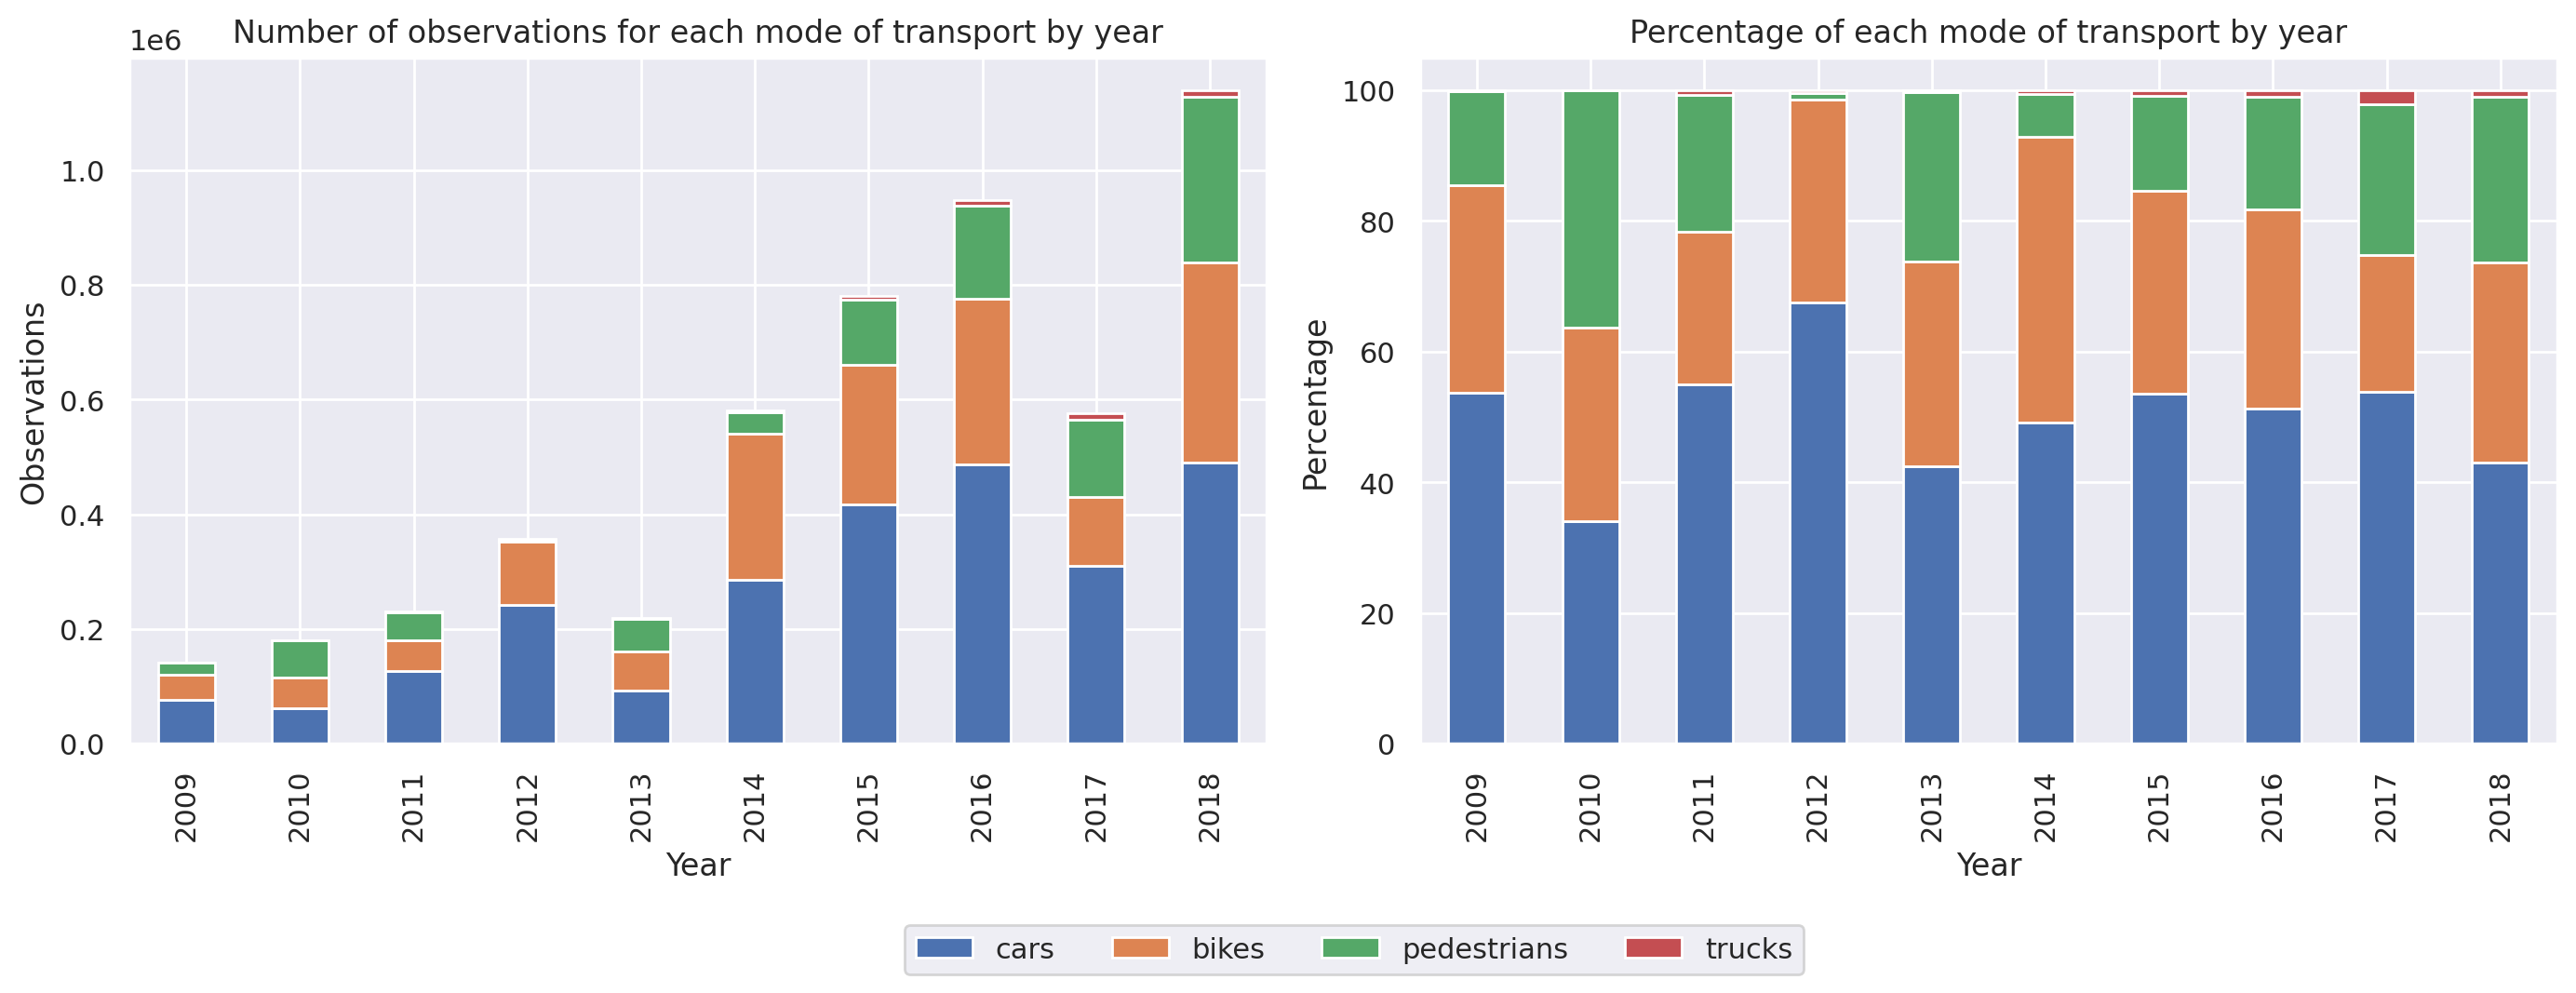

In [ ]:
modes_of_transport = ['cars', 'bikes', 'pedestrians', 'trucks']

df_tt['year'] = df_tt['date'].dt.year
df_year_count = df_tt[modes_of_transport+['year']].groupby('year').sum()

df_year_fraction = pd.DataFrame()
for i in range(len(modes_of_transport)):
    df_year_fraction[modes_of_transport[i]] = df_year_count[modes_of_transport[i]]/df_year_count.sum(axis=1)*100

fig, ax = plt.subplots(1, 2, figsize=(14,5), dpi=200)
p1 = df_year_count.plot.bar(stacked='True', ax=ax[0], 
                       title='Number of observations for each mode of transport by year',
                       xlabel='Year',
                       ylabel='Observations',
                       legend=0)

p2 = df_year_fraction.plot.bar(stacked='True', ax=ax[1], 
                       title='Percentage of each mode of transport by year',
                       xlabel='Year',
                       ylabel='Percentage',
                       legend=0)

plt.tight_layout()
plt.legend(loc='right', bbox_to_anchor=(0.35, -0.3), ncol=5)
plt.show()

We see that the number of observations taken for each year is increasing for each year. Since we are working with count data, this is not entirely surprising, as there are some years, where more measurements were taken, than others, as was seen earlier. As more measurements a year directly leads to more observations, it might be difficult to conclude whether there has been an increase in traffic during the 10-year time period. Such rise could also be correlated to how there have been more people moving to Copenhagen during recent years **[REF?]**. 

Thus it would be beneficial for us to look at the fraction for which each mode of transport constitutes each year. As we see, *Cars* is the dominant group each year, consisting of approximately half of the observations, making it quite difficult to exactly see if there has been such a shift.

In an ideal world, we would automatically capture the number of cars, bikes etc. all 365 days of the year at the same locations each time. But as we already know, there is variation in the amount of measurements each year. We can take a closer look at exactly which dates, these measurements are taken and how many of them that are taken during one year, e.g. in 2018:

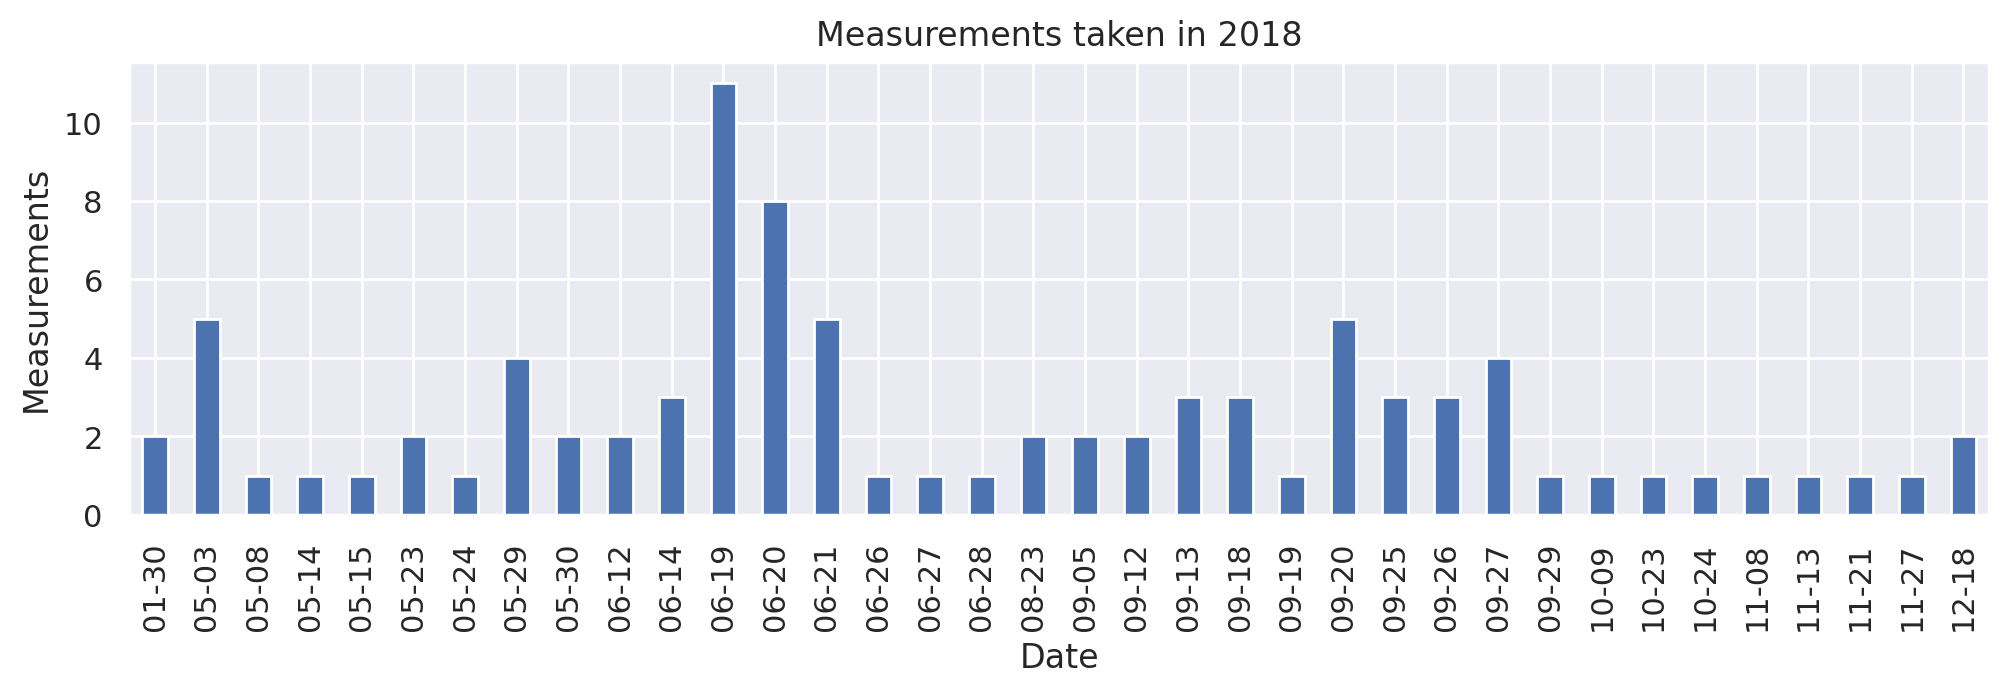

In [ ]:
df_2019_measurements = df_tt[df_tt.year == 2018].groupby('date').size()

fig, ax = plt.subplots(figsize=(12,3), dpi=200)
df_2019_measurements.plot(kind='bar',
                          ax=ax,
                          xlabel='Date',
                          ylabel='Measurements',
                          title='Measurements taken in 2018')
ax.set_xticklabels([x.strftime("%m-%d") for x in df_2019_measurements.index])
plt.show()

As we see, there is also a lot of variation in terms of how many measurements are taken each day. Some days, there has only been one measurement, meaning they have only counted from one location, while other days, there have been countings at 11 locations. This causes problems, since the more places you count, the more observations you will get.

It also seems to be that during the Spring and Fall months, more measurements have been taken. We can try and plot the total observations, i.e. the sum of observations for each month throughout our time period:

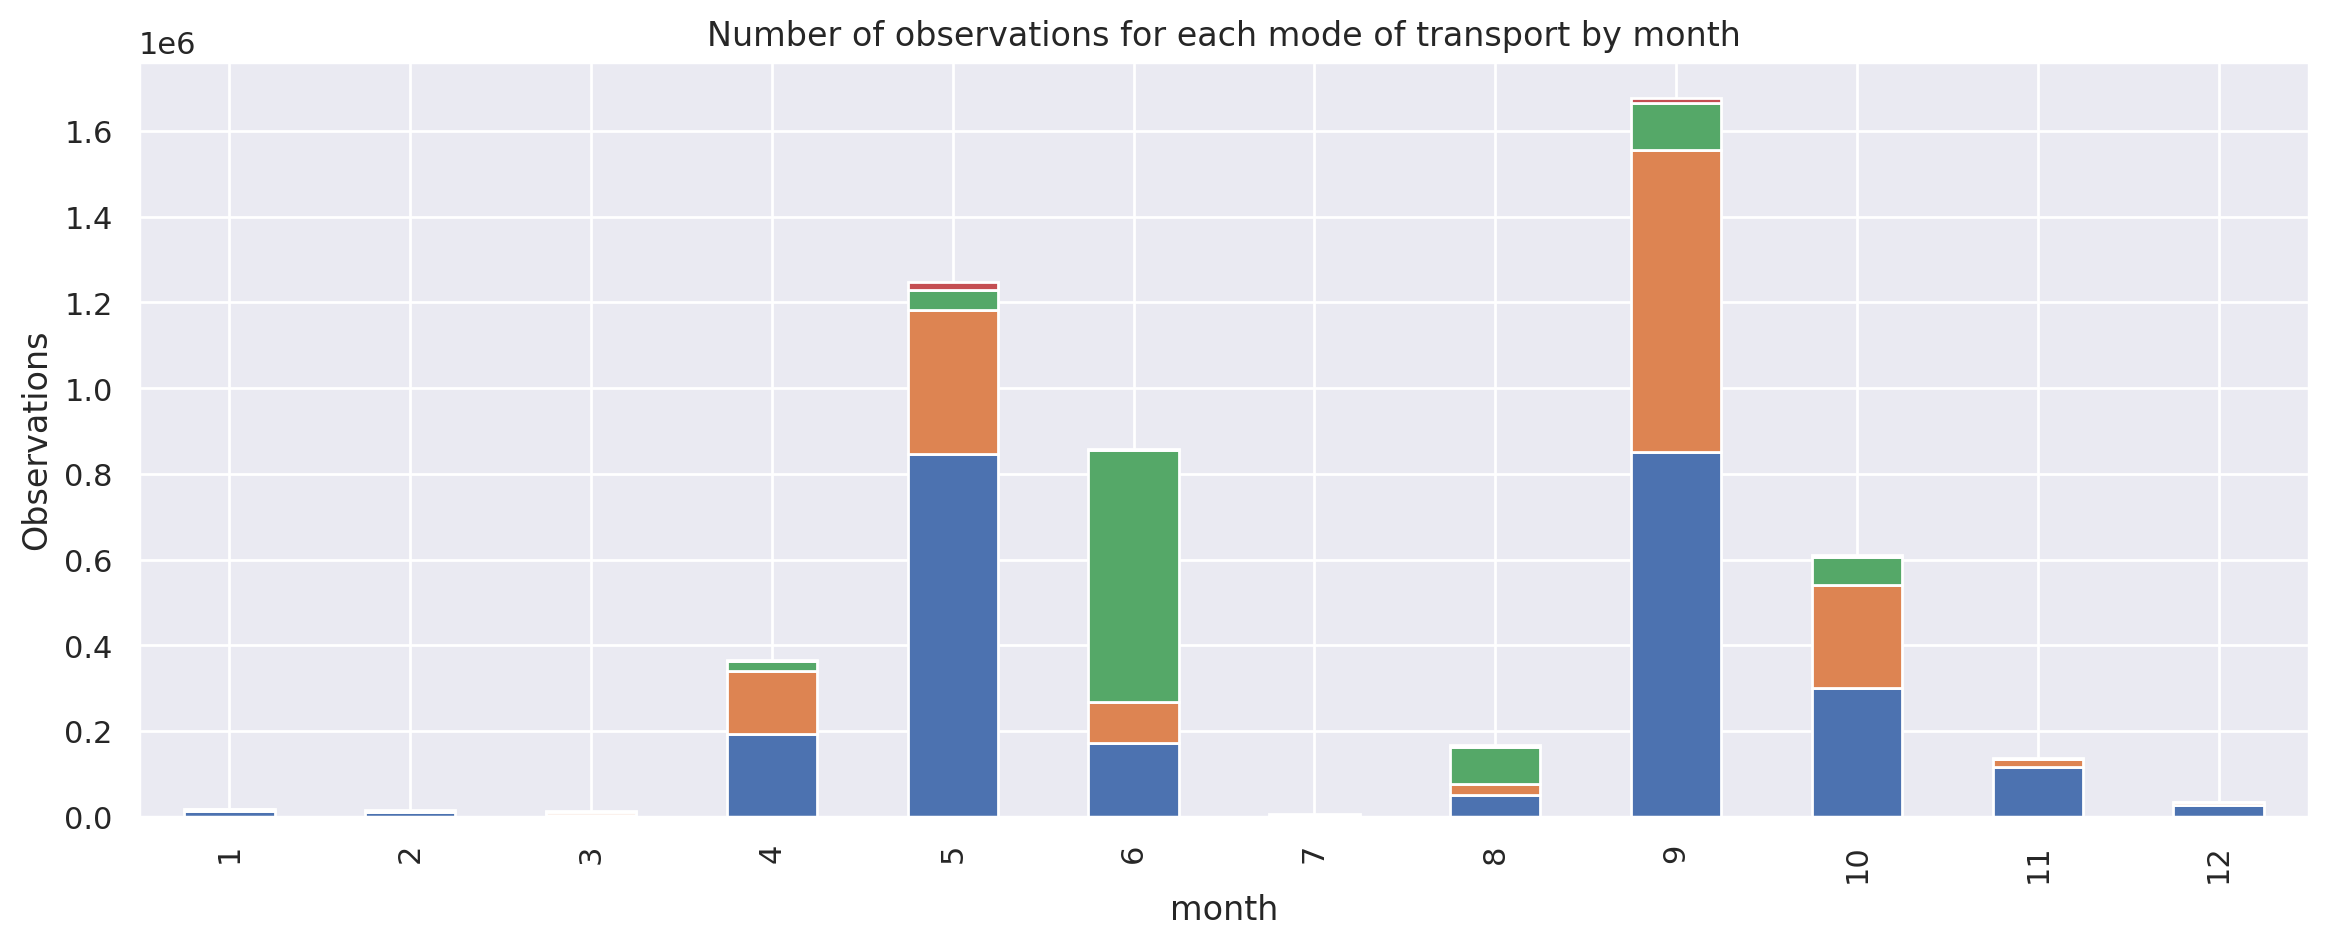

In [ ]:
df_tt['month'] = df_tt['date'].dt.month
df_month_count = df_tt[modes_of_transport+['month']].groupby('month').sum()
fig, ax = plt.subplots(figsize=(14,5), dpi=200)
p1 = df_month_count.plot.bar(stacked='True', ax=ax, 
                       title='Number of observations for each mode of transport by month',
                       xlabel='month',
                       ylabel='Observations',
                       legend=0)

It becomes very apparent that the measurements are mainly taken in April-June and August-November (some may argue that it is actually September-October). 

According to **[REF TIL AASES PDF]**, the measurements are taken during Spring and Fall. In Spring, measurements are taken of vehicles and bicycles - not pedestrians, while in Fall, measurements are also taken on vehicles and bicycles, but also pedestrians on certain locations. 

Besides these measurements, the municipality also runs a rotation program, where all of the neighbourhoods/districts within Copenhagen are measured. Here, vehicles and bycicles are counted, but not pedestrians. This is to ensure that we get a picture of the traffic in the entire city. They also do what they call "Other measurements", which are measurements provided for institutions (Aarhus University and Vejdirektoratet).

One may also wonder about the larger fraction of countings in June and August. Each year during these months, pedestrians are counted on selected pedestrian streets.

It seems that including pedestrians makes our analysis quite difficult due to the large invariance of when they are measured. We thus filter out the pedestrians and trucks so that the focus is on bikes and cars only.

In [ ]:
df_tt = df_tt.drop(columns=['pedestrians', 'trucks'])

We would also like to inspect how many times each location has been captured and if there is a large variation in that:

In [ ]:
df_tt.groupby(['lon', 'lat']).size().sort_values(ascending=False).head(10)

lon        lat      
12.583663  55.720094    3
12.531054  55.702777    2
12.591272  55.679583    2
12.577511  55.715634    2
12.541107  55.704659    2
12.461512  55.711871    1
12.574385  55.689409    1
12.574485  55.684278    1
12.574606  55.684320    1
12.574634  55.689666    1
dtype: int64

The maximum amount of times each location has been captured is just 3 times, while most locations have just been measured once. We now take a look at exactly where these locations are:

In [ ]:
# plot a map of Copenhagen
map_hooray = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Plotting the points using folium's CircleMarker
# Loop over data, and include a couple extra information for each crime
for lng, lat in zip(df_tt.lon, df_tt.lat):
    folium.CircleMarker([lat, lng], radius=1.5,
                         fill=True
                         ).add_to(map_hooray)

# Show the map
map_hooray

So, most of the places where measurements have been taken are at larger/main roads. We see that there are large clusters around central copenhagen, Vesterbro and Nørrebro, not surprisingly as these areas are very populated.

For our further analysis, this also means that there are definitely things that we have to take into account when working with this dataset:
1. It is difficult to look at all locations and see if look for changes in terms of cars and bikes, since some years have been measured less than others and the population density has increased.

2. We cannot take out specific point locations on the map and look for changes in those. Instead, we could look for roads or neighbourhoods within Copenhagen, to look for changes in a much larger area. This could be by creating heatmaps, or subdividing it into neighbourhoods and taking the sum of observations.

In [ ]:
df_tt = df_tt[~(df_tt.cars.isna() & df_tt.bikes.isna())]
df_tt

,t_nr,cars,bikes,date,lon,lat,year,month
0,1,42650.0,21601.0,2016-09-21,12.565491,55.677961,2016,9
7,9,531.0,2724.0,2015-10-01,12.572504,55.675972,2015,10
8,11,64.0,1260.0,2018-06-19,12.572684,55.683211,2018,6
17,21,14553.0,4409.0,2017-05-17,12.524266,55.696774,2017,5
22,27,3979.0,15755.0,2018-09-27,12.582296,55.679986,2018,9
...,...,...,...,...,...,...,...,...
1043,10151,35.0,418.0,2018-05-03,12.569577,55.683120,2018,5
1057,10176,NaN,1021.0,2009-09-24,12.570894,55.696426,2009,9
1068,10190,NaN,3017.0,2009-09-24,12.569539,55.702337,2009,9
1069,10192,716.0,1413.0,2010-04-21,12.555246,55.691003,2010,4


## 3. Data Analysis

* Describe your data analysis and explain what you've learned about the dataset. 
* If relevant, talk about your machine-learning.

### 3.1 Temporal Patterns

For analyzing temporal patterns, we need our second dataset, which the primary dataset is based on.

In [ ]:
df_traffic = pd.read_excel('data/SQL_2019.xlsx',
                            parse_dates= {"date" : ["ÅR","DATO"]})

df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y %m%d')

In [ ]:
df_traffic

,date,TS,VEJNAVN,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,ANTAL 10-11,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19
0,2002-05-07,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,FRA BYEN,PERSONBILER,153.0,415.0,495.0,364.0,441.0,493.0,561.0,523.0,564.0,746.0,694.0,630.0,NaN
1,2002-05-07,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,FRA BYEN,MOTORCYKLER,7.0,15.0,12.0,15.0,6.0,11.0,9.0,7.0,14.0,29.0,37.0,22.0,NaN
2,2002-05-07,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,FRA BYEN,"VAREVOGNE (MAX. 3,5 T)",43.0,68.0,68.0,104.0,110.0,142.0,102.0,123.0,115.0,170.0,87.0,61.0,NaN
3,2002-05-07,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,FRA BYEN,A: LET TRAFIK IALT,203.0,498.0,575.0,483.0,557.0,646.0,672.0,653.0,693.0,945.0,818.0,713.0,NaN
4,2002-05-07,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,FRA BYEN,"LASTBILER, 2 AKSLER",17.0,31.0,30.0,26.0,35.0,37.0,35.0,50.0,32.0,29.0,24.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148810,2018-06-20,7635,VESTERBROGADE 3,Mod sydvest (Vesterbro),Mænd,NaN,41.0,76.0,115.0,198.0,414.0,441.0,433.0,519.0,634.0,729.0,790.0,714.0
148811,2018-06-20,7635,VESTERBROGADE 3,Mod sydvest (Vesterbro),Børn under 12 år,NaN,0.0,0.0,10.0,11.0,37.0,57.0,40.0,70.0,40.0,66.0,38.0,42.0
148812,2018-06-20,7635,VESTERBROGADE 3,Mod sydvest (Vesterbro),Barnevogne,NaN,0.0,1.0,4.0,6.0,24.0,23.0,15.0,22.0,28.0,23.0,18.0,18.0
148813,2018-06-20,7635,VESTERBROGADE 3,Mod sydvest (Vesterbro),Løbere,NaN,3.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
df_traffic[df_traffic.date.dt.year > 2008].groupby('KATEGORI').size().sort_values(ascending=False).head(20)

KATEGORI
VAREVOGNE (MAX. 3,5 T)             2376
CYKLER + KNALLERTER                2126
B: TUNG TRAFIK I ALT               2103
A: LET TRAFIK I ALT                2102
A+B: KØRETØJER I ALT               2095
LADCYKLER                          1952
PERSONBILER                        1949
MOTORCYKLER                        1949
BUSSER I FAST RUTE                 1930
ANDRE BUSSER                       1929
CYKLER + KNALLERTER I ALT          1700
LASTBILER, 2 AKSLER                1054
LASTBILER, 3 AKSLER                1054
LASTBILER, 4 - FLERE AKSLER         881
LASTBILER, 3 aksler                 578
LASTBILER, 4 - flere aksler         578
LASTBILER, 2 aksler                 578
CYKLER + KNALLERTER + LADCYKLER     470
PERSONBILER + MOTORCYKL.            433
SOLOLASTBILER, 2 AKSLER             317
dtype: int64

In [ ]:
df_traffic_filter = df_traffic[df_traffic.date.dt.year > 2008]
df_traffic_filter['date'] = pd.to_datetime(df_traffic_filter['date']).dt.date
df_traffic_filter = df_traffic_filter[(df_traffic_filter['KATEGORI'].str.lower() == 'personbiler') | (df_traffic_filter['KATEGORI'].str.lower() == 'cykler + knallerter')]
df_traffic_filter = df_traffic_filter[['TS', 'date', 'KATEGORI', 'ANTAL 7-8', 'ANTAL 8-9', 
                                       'ANTAL 9-10', 'ANTAL 10-11', 'ANTAL 11-12', 'ANTAL 12-13', 
                                       'ANTAL 13-14', 'ANTAL 14-15', 'ANTAL 15-16', 'ANTAL 16-17',
                                       'ANTAL 17-18', 'ANTAL 18-19']]
df_traffic_filter.rename(columns={
    "TS": "t_nr", 
    "ÅR": "year",
    "DATO": "date",
    "KATEGORI": "category",
    "ANTAL 7-8": "7-8",
    'ANTAL 8-9': '8-9',
    'ANTAL 9-10': '9-10',
    'ANTAL 10-11': '10-11', 
    'ANTAL 11-12': '11-12', 
    'ANTAL 12-13': '12-13', 
    'ANTAL 13-14': '13-14', 
    'ANTAL 14-15': '14-15', 
    'ANTAL 15-16': '15-16', 
    'ANTAL 16-17': '16-17',
    'ANTAL 17-18': '17-18', 
    'ANTAL 18-19': '18-19'
    }, inplace=True)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


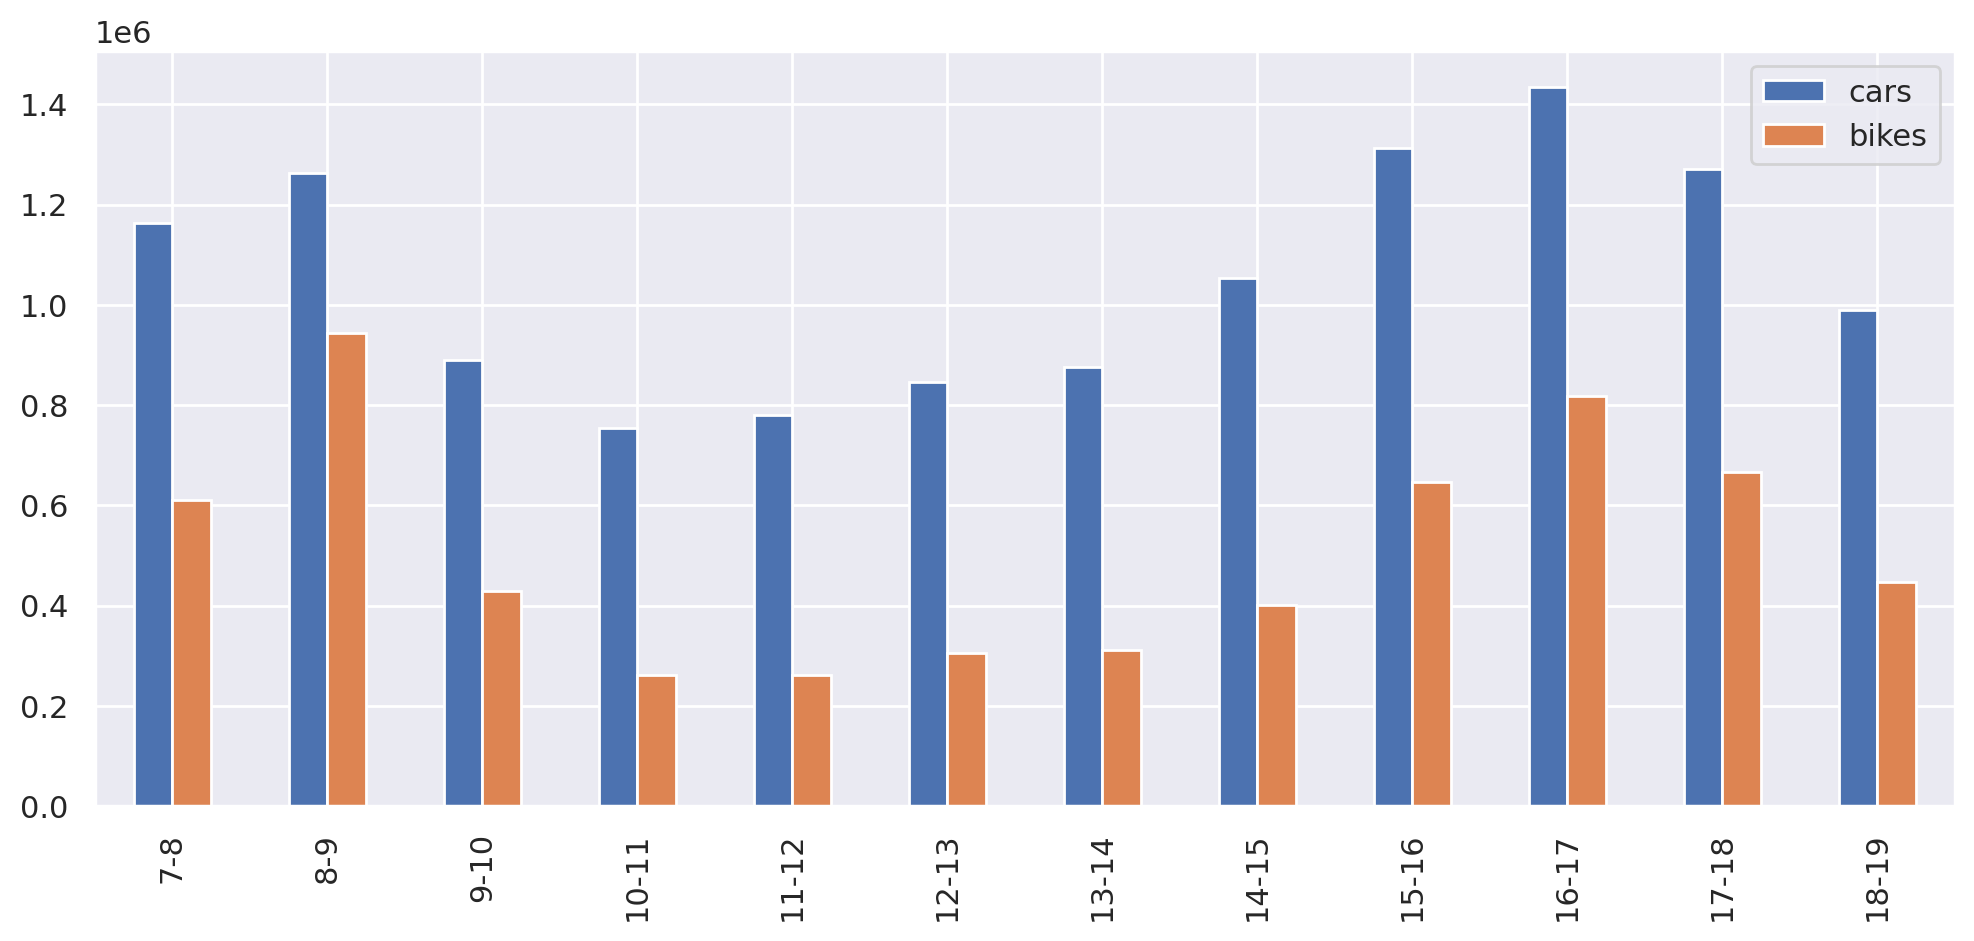

In [ ]:
df_traffic_filter_cars = df_traffic_filter[df_traffic_filter.category == 'PERSONBILER']
df_traffic_filter_bikes = df_traffic_filter[df_traffic_filter.category == 'CYKLER + KNALLERTER']

df_traffic_hour = pd.DataFrame()
df_traffic_hour['cars'] = df_traffic_filter_cars[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()
df_traffic_hour['bikes'] = df_traffic_filter_bikes[["7-8", '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', 
                        '16-17', '17-18', '18-19']].sum()

fig, axes = plt.subplots(figsize=(12,5), dpi=200, sharex='all')
df_traffic_hour.plot(kind='bar', ax=axes)
plt.show()

In [ ]:
df_traffic_filter

,t_nr,date,category,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19
19610,117,2009-04-30,PERSONBILER,276.0,417.0,305.0,329.0,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0
19622,117,2009-04-30,CYKLER + KNALLERTER,345.0,492.0,264.0,218.0,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0
19624,117,2009-04-30,PERSONBILER,327.0,535.0,397.0,405.0,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0
19636,117,2009-04-30,CYKLER + KNALLERTER,355.0,883.0,553.0,353.0,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0
19648,122,2009-09-03,PERSONBILER,225.0,338.0,279.0,283.0,331.0,370.0,373.0,432.0,466.0,642.0,568.0,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148364,9865,2018-05-17,CYKLER + KNALLERTER,639.0,884.0,184.0,92.0,77.0,100.0,121.0,187.0,381.0,380.0,347.0,194.0
148426,9889,2018-05-29,PERSONBILER,164.0,197.0,96.0,128.0,114.0,148.0,157.0,193.0,297.0,246.0,204.0,142.0
148438,9889,2018-05-29,CYKLER + KNALLERTER,160.0,135.0,82.0,67.0,73.0,90.0,152.0,204.0,346.0,353.0,225.0,164.0
148440,9889,2018-05-29,PERSONBILER,250.0,287.0,179.0,146.0,116.0,115.0,163.0,167.0,212.0,255.0,184.0,140.0


### 3.2 Spatial Patterns

In [ ]:
# Aggregating by Zone
df = df.groupby('zone').sum()
df = df.reset_index(drop=False)

# Displaying result
df.head()

In [ ]:
# Import copenhagen districts (ref: https://giedriusk.carto.com/tables/copenhagen_districts/public)
districts = gpd.read_file('data/copenhagen_districts.geojson')

# Find unique districts
df_districts = pd.DataFrame(districts['name'].unique(), columns=["DISTRICTS"])
df_districts['VALUES'] = 0

In [ ]:
# Plot heatmap with districts

# import copenhagen districts as json
with open('data/copenhagen_districts.geojson') as f:
    data = json.load(f)

Choropleth = folium.Choropleth(geo_data=data, data=df_districts, columns=['DISTRICTS', 'VALUES'], key_on='feature.properties.name', fill_opacity=0, line_opacity=1, line_weight=2)
# Adding the data to the map
Choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['name']))

# Deleting legend bar for the color schema (If we have fill_opacity = 0)
for keys in Choropleth._children:
    if keys.startswith('color_map'):
        del(Choropleth._children[keys])

# Extract the cols containing bikes
cols_of_interest = ['t_nr','bikes', 'date', 'lon', 'lat', 'year']
df_bikes = df_tt[cols_of_interest]
df_bikes = df_bikes[~df_bikes.bikes.isna()]

# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['bikes']] for index, row in df_bikes.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)


# Adding color palette
map_copenhagen

In [ ]:
# Extract the cols containing bikes
cols_of_interest = ['t_nr','cars', 'date', 'lon', 'lat', 'year']
df_cars = df_tt[cols_of_interest]
df_cars = df_cars[~df_cars.cars.isna()]

# Finding the relevant lon and lat coordinates
heat_data = [[row['lat'], row['lon'], row['cars']] for index, row in df_cars.iterrows()]

# Creating the map
map_copenhagen = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 12,dpi=500)

# Adding Districts
Choropleth.add_to(map_copenhagen)

# Adding the data to the map
HeatMap(heat_data, radius=15, blur=25).add_to(map_copenhagen)


# Adding color palette
map_copenhagen

### 3.3 Weather

In [ ]:
# Copenhagen
# (lon, lat) 12.447848,55.606376,12.692826,55.731079

url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

header={'X-Gravitee-Api-Key': '4017479a-aed9-4909-aaac-0cb6169d7743'} #hidden 

# Parameters: https://confluence.govcloud.dk/pages/viewpage.action?pageId=26476616
param_list = ['temp_mean_past1h','wind_speed_past1h','precip_past1h']

#Construct weather dataframe
df_weather = pd.DataFrame()

for param in param_list:

    # Specify query parameters
    params = {'datetime' : '2009-01-01T00:00:00Z/2018-12-31T23:59:00Z',
            'parameterId' : param,
            'limit' : '300000',
            # Use bbox from above
            'bbox' : '12.447848,55.606376,12.692826,55.731079'
            }


    r = requests.get(url,headers=header,params=params) # submit GET request based on url and headers
    json_t = r.json()['features']
    df_weather_t = pd.json_normalize(json_t)
    df_weather = pd.concat([df_weather, df_weather_t])

### Data preprocessing

In [ ]:
# Convert to 'datetime'
df_weather['properties.observed'] = pd.to_datetime(df_weather['properties.observed']).dt.tz_localize(None)

# Save columns including date and time
df_weather['date'] = pd.to_datetime(df_weather['properties.observed']).dt.date
df_weather['time'] = pd.to_datetime(df_weather['properties.observed']).dt.time

# Select coloumns of interest
df_weather = df_weather[['geometry.coordinates', 'properties.observed', 'date', 'time', 'properties.parameterId', 'properties.value']]

In [ ]:
df_temp = df_weather[df_weather['properties.parameterId'] == 'temp_mean_past1h'].groupby(pd.Grouper(key='date')).agg({ 'properties.value': 'mean'})
#df_wind = df_weather[df_weather['properties.parameterId'] == 'wind_speed_past1h'].groupby(pd.Grouper(key='properties.observed')).agg({ 'properties.value': 'mean'})
#df_precip = df_weather[df_weather['properties.parameterId'] == 'precip_past1h'].groupby(pd.Grouper(key='properties.observed')).agg({ 'properties.value': 'mean'})

In [ ]:
df_traffic_filter

,t_nr,date,category,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19
19610,117,2009-04-30,PERSONBILER,276.0,417.0,305.0,329.0,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0
19622,117,2009-04-30,CYKLER + KNALLERTER,345.0,492.0,264.0,218.0,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0
19624,117,2009-04-30,PERSONBILER,327.0,535.0,397.0,405.0,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0
19636,117,2009-04-30,CYKLER + KNALLERTER,355.0,883.0,553.0,353.0,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0
19648,122,2009-09-03,PERSONBILER,225.0,338.0,279.0,283.0,331.0,370.0,373.0,432.0,466.0,642.0,568.0,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148364,9865,2018-05-17,CYKLER + KNALLERTER,639.0,884.0,184.0,92.0,77.0,100.0,121.0,187.0,381.0,380.0,347.0,194.0
148426,9889,2018-05-29,PERSONBILER,164.0,197.0,96.0,128.0,114.0,148.0,157.0,193.0,297.0,246.0,204.0,142.0
148438,9889,2018-05-29,CYKLER + KNALLERTER,160.0,135.0,82.0,67.0,73.0,90.0,152.0,204.0,346.0,353.0,225.0,164.0
148440,9889,2018-05-29,PERSONBILER,250.0,287.0,179.0,146.0,116.0,115.0,163.0,167.0,212.0,255.0,184.0,140.0


In [ ]:
df_traffic_filter['date_new'] = pd.to_datetime(df_traffic_filter['year'] + df_traffic_filter['date'], format='%y%m%d')

KeyError: 'year'

In [ ]:
df_traffic_filter[df_traffic_filter.t_nr == 117]

,t_nr,date,category,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19
19610,117,2009-04-30,PERSONBILER,276.0,417.0,305.0,329.0,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0
19622,117,2009-04-30,CYKLER + KNALLERTER,345.0,492.0,264.0,218.0,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0
19624,117,2009-04-30,PERSONBILER,327.0,535.0,397.0,405.0,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0
19636,117,2009-04-30,CYKLER + KNALLERTER,355.0,883.0,553.0,353.0,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0
22752,117,2010-05-06,PERSONBILER,274.0,336.0,255.0,318.0,397.0,456.0,416.0,506.0,556.0,550.0,381.0,472.0
22764,117,2010-05-06,CYKLER + KNALLERTER,404.0,428.0,205.0,135.0,215.0,315.0,276.0,431.0,713.0,791.0,532.0,540.0
22766,117,2010-05-06,PERSONBILER,381.0,498.0,411.0,397.0,395.0,454.0,434.0,464.0,456.0,406.0,445.0,374.0
22778,117,2010-05-06,CYKLER + KNALLERTER,650.0,1010.0,494.0,206.0,164.0,116.0,265.0,326.0,422.0,411.0,313.0,230.0
25581,117,2011-05-03,PERSONBILER,239.0,284.0,245.0,281.0,323.0,337.0,538.0,542.0,625.0,469.0,425.0,411.0
25593,117,2011-05-03,CYKLER + KNALLERTER,411.0,436.0,209.0,212.0,269.0,345.0,277.0,409.0,563.0,785.0,675.0,444.0


In [ ]:
df_temp

,properties.value
date,
2018-12-31,5.120833
2018-12-30,4.714583
2018-12-29,6.904167
2018-12-28,6.308333
2018-12-27,7.918750
...,...
2009-01-05,-5.068750
2009-01-04,-2.816667
2009-01-03,1.170833


In [ ]:
df_precip['datetime'] = pd.to_datetime(df_precip.index)
df_precip['date'] = pd.to_datetime(df_precip['datetime']).dt.date
df_precip['time'] = pd.to_datetime(df_precip['datetime']).dt.time

In [ ]:
df_trafic_filter

NameError: name 'df_trafic_filter' is not defined

## 4. Genre.

* Which genre of data story did you use?
* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?


## 5. Visualizations.


* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

## 6. Discussion. Think critically about your creation

* What went well?
* What is still missing? What could be improved? Why?

## Contributions. Who did what?

* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".

In [ ]:
pd.DataFrame({'Mean': df_year_count.mean(), 'Median': df_year_count.median(), 'Standard Deviation': df_year_count.std()}).round(decimals=2)

,Mean,Median,Standard Deviation
cars,367173.27,286021.0,392750.50
bikes,208779.36,120048.0,198244.31
pedestrians,99031.45,65641.0,83254.15
trucks,7540.36,3310.0,10366.71
electric scooters,552.91,0.0,1833.79


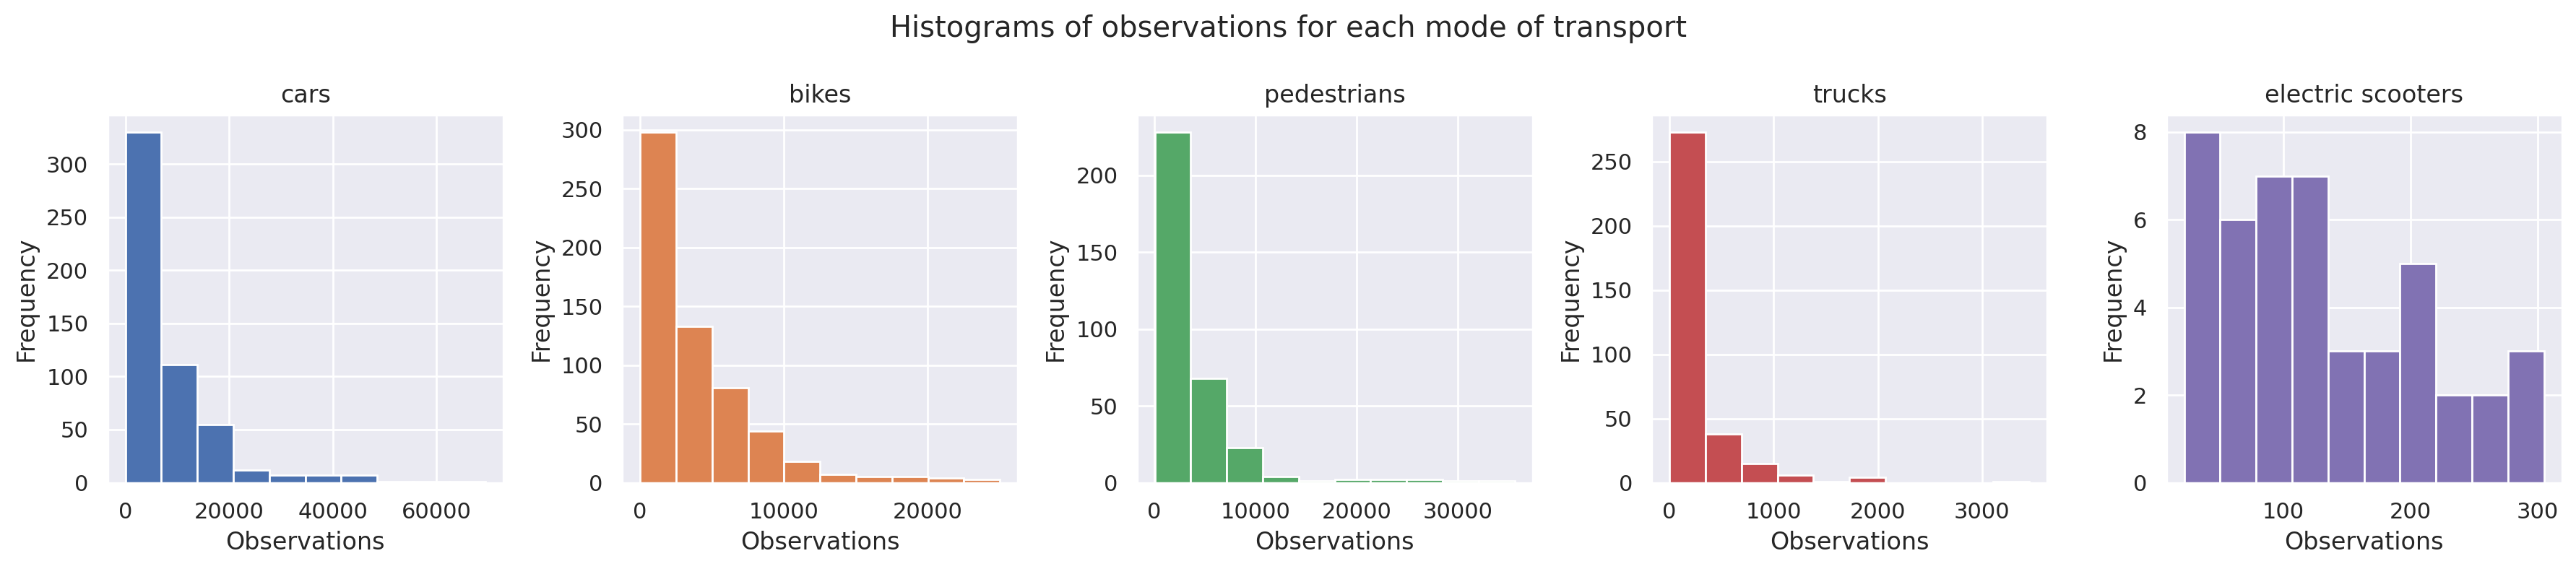

In [ ]:
palette = sns.color_palette()

fig, axes = plt.subplots(1,5, figsize=(18,4), dpi=200)
for i in range(len(modes_of_transport)):
    df_tt[[modes_of_transport[i]]].hist(ax=axes[i], color= palette[i])
    axes[i].set_xlabel("Observations")
    axes[i].set_ylabel("Frequency")
fig.suptitle('Histograms of observations for each mode of transport')
plt.tight_layout()
#plt.savefig('Histograms.png')
plt.show()

## Time Data

In [ ]:
# Data preparation
df_traffic = pd.read_excel('data/SQL_2019.xlsx')
df_traffic

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [ ]:
# Merge the two dataframes to get coordinates (t_nr and TS keys)
df_merged = df_traffic_filter.merge(df_tt[['t_nr', 'lon', 'lat']], left_on='t_nr', right_on='t_nr', how='outer')

In [ ]:
df_merged

,t_nr,date,category,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,lon,lat
0,117,2009-04-30,PERSONBILER,276.0,417.0,305.0,329.0,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,NaN,NaN
1,117,2009-04-30,CYKLER + KNALLERTER,345.0,492.0,264.0,218.0,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0,NaN,NaN
2,117,2009-04-30,PERSONBILER,327.0,535.0,397.0,405.0,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0,NaN,NaN
3,117,2009-04-30,CYKLER + KNALLERTER,355.0,883.0,553.0,353.0,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0,NaN,NaN
4,117,2010-05-06,PERSONBILER,274.0,336.0,255.0,318.0,397.0,456.0,416.0,506.0,556.0,550.0,381.0,472.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,10151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.569577,55.683120
4368,10176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.570894,55.696426
4369,10190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.569539,55.702337
4370,10192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555246,55.691003


In [ ]:
df_traffic_filter

,t_nr,year,date,category,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,date_new
19610,117,2009,430,PERSONBILER,276.0,417.0,305.0,329.0,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,1900-04-30
19622,117,2009,430,CYKLER + KNALLERTER,345.0,492.0,264.0,218.0,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0,1900-04-30
19624,117,2009,430,PERSONBILER,327.0,535.0,397.0,405.0,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0,1900-04-30
19636,117,2009,430,CYKLER + KNALLERTER,355.0,883.0,553.0,353.0,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0,1900-04-30
19648,122,2009,903,PERSONBILER,225.0,338.0,279.0,283.0,331.0,370.0,373.0,432.0,466.0,642.0,568.0,438.0,1900-09-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148364,9865,2018,517,CYKLER + KNALLERTER,639.0,884.0,184.0,92.0,77.0,100.0,121.0,187.0,381.0,380.0,347.0,194.0,1900-05-17
148426,9889,2018,529,PERSONBILER,164.0,197.0,96.0,128.0,114.0,148.0,157.0,193.0,297.0,246.0,204.0,142.0,1900-05-29
148438,9889,2018,529,CYKLER + KNALLERTER,160.0,135.0,82.0,67.0,73.0,90.0,152.0,204.0,346.0,353.0,225.0,164.0,1900-05-29
148440,9889,2018,529,PERSONBILER,250.0,287.0,179.0,146.0,116.0,115.0,163.0,167.0,212.0,255.0,184.0,140.0,1900-05-29


In [ ]:
# Take values from 2009
df = df_merged[df_merged['ÅR'] >= 2009]

# Filter away nan values
df = df[~df['wkb_geometry'].isna()]

In [ ]:
df

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19834,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,PERSONBILER,NaN,276.0,417.0,305.0,...,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,117.0,POINT (12.53403496752496 55.70169207674738)
19835,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,MOTORCYKLER,NaN,5.0,2.0,2.0,...,8.0,4.0,5.0,3.0,9.0,12.0,5.0,6.0,117.0,POINT (12.53403496752496 55.70169207674738)
19836,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,"VAREVOGNE (MAX. 3,5 T)",NaN,40.0,51.0,59.0,...,155.0,155.0,89.0,79.0,71.0,97.0,71.0,73.0,117.0,POINT (12.53403496752496 55.70169207674738)
19837,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,A: LET TRAFIK IALT,NaN,321.0,470.0,366.0,...,555.0,589.0,547.0,620.0,631.0,578.0,569.0,595.0,117.0,POINT (12.53403496752496 55.70169207674738)
19838,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,"SOLOLASTBILER, 2 AKSLER",NaN,17.0,21.0,18.0,...,7.0,6.0,15.0,16.0,11.0,4.0,2.0,2.0,117.0,POINT (12.53403496752496 55.70169207674738)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150182,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Mænd,NaN,41.0,76.0,115.0,...,414.0,441.0,433.0,519.0,634.0,729.0,790.0,714.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150183,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Børn under 12 år,NaN,0.0,0.0,10.0,...,37.0,57.0,40.0,70.0,40.0,66.0,38.0,42.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150184,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Barnevogne,NaN,0.0,1.0,4.0,...,24.0,23.0,15.0,22.0,28.0,23.0,18.0,18.0,7635.0,POINT (12.565946323498252 55.67490460097625)
150185,7635,VESTERBROGADE 3,2018,620,Mod sydvest (Vesterbro),Løbere,NaN,3.0,2.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7635.0,POINT (12.565946323498252 55.67490460097625)


In [ ]:
df_filter = df[(df['KATEGORI'].str.lower() == 'personbiler') | (df['KATEGORI'].str.lower() == 'cykler + knallerter')]
df_filter

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19834,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,PERSONBILER,NaN,276.0,417.0,305.0,...,392.0,430.0,453.0,538.0,551.0,469.0,493.0,516.0,117.0,POINT (12.53403496752496 55.70169207674738)
19846,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,CYKLER + KNALLERTER,NaN,345.0,492.0,264.0,...,250.0,260.0,262.0,425.0,621.0,847.0,751.0,580.0,117.0,POINT (12.53403496752496 55.70169207674738)
19848,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,PERSONBILER,NaN,327.0,535.0,397.0,...,441.0,464.0,457.0,536.0,517.0,618.0,636.0,456.0,117.0,POINT (12.53403496752496 55.70169207674738)
19860,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,CYKLER + KNALLERTER,NaN,355.0,883.0,553.0,...,355.0,347.0,295.0,379.0,507.0,541.0,499.0,358.0,117.0,POINT (12.53403496752496 55.70169207674738)
19872,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD VEST,PERSONBILER,NaN,225.0,338.0,279.0,...,331.0,370.0,373.0,432.0,466.0,642.0,568.0,438.0,122.0,POINT (12.556001299281931 55.67382051591301)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149736,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod syd (byen),CYKLER + KNALLERTER,NaN,639.0,884.0,184.0,...,77.0,100.0,121.0,187.0,381.0,380.0,347.0,194.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149798,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),PERSONBILER,NaN,164.0,197.0,96.0,...,114.0,148.0,157.0,193.0,297.0,246.0,204.0,142.0,9889.0,POINT (12.49264558961257 55.68485527143219)
149810,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),CYKLER + KNALLERTER,NaN,160.0,135.0,82.0,...,73.0,90.0,152.0,204.0,346.0,353.0,225.0,164.0,9889.0,POINT (12.49264558961257 55.68485527143219)
149812,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod sydøst (Grøndals Parkvej),PERSONBILER,NaN,250.0,287.0,179.0,...,116.0,115.0,163.0,167.0,212.0,255.0,184.0,140.0,9889.0,POINT (12.49264558961257 55.68485527143219)


In [ ]:
df_filter.groupby('TS').size()

TS
1        32
9         2
12       32
13       40
14       40
         ..
10128     4
10131     4
10144     4
10145     4
10146     4
Length: 296, dtype: int64

In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER + LADCYKLER']

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
19847,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,FRA BYEN,CYKLER + KNALLERTER + LADCYKLER,NaN,346.0,496.0,265.0,...,252.0,262.0,262.0,425.0,623.0,855.0,756.0,585.0,117.0,POINT (12.53403496752496 55.70169207674738)
19861,117,FREDERIKSSUNDSVEJ øst for Frederiksborgvej,2009,430,MOD BYEN,CYKLER + KNALLERTER + LADCYKLER,NaN,358.0,888.0,561.0,...,361.0,350.0,299.0,388.0,515.0,545.0,502.0,361.0,117.0,POINT (12.53403496752496 55.70169207674738)
19885,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD VEST,CYKLER + KNALLERTER + LADCYKLER,NaN,237.0,338.0,208.0,...,174.0,188.0,196.0,334.0,594.0,1060.0,799.0,508.0,122.0,POINT (12.556001299281931 55.67382051591301)
19899,122,GAMMEL KONGEVEJ 23 øst for Vordroffsvej,2009,903,MOD ØST,CYKLER + KNALLERTER + LADCYKLER,NaN,666.0,1358.0,547.0,...,240.0,225.0,165.0,326.0,400.0,504.0,422.0,388.0,122.0,POINT (12.556001299281931 55.67382051591301)
19913,123,GL. KØGE LANDEVEJ syd for Toftegårds Plads,2009,514,MOD NORD,CYKLER + KNALLERTER + LADCYKLER,NaN,231.0,267.0,99.0,...,85.0,77.0,88.0,64.0,131.0,152.0,130.0,92.0,123.0,POINT (12.514686665905312 55.65901039277438)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28766,902,VESTERBROGADE øst for Pile Allé,2011,505,MOD ØST (MOD BYEN),CYKLER + KNALLERTER + LADCYKLER,NaN,249.0,417.0,165.0,...,107.0,130.0,96.0,125.0,181.0,284.0,215.0,174.0,902.0,POINT (12.531984797933 55.6707659504385)
28780,903,PILE ALLÉ syd for Vesterbrogade,2011,505,MOD NORD,CYKLER + KNALLERTER + LADCYKLER,NaN,250.0,360.0,164.0,...,116.0,90.0,117.0,124.0,222.0,254.0,228.0,151.0,903.0,POINT (12.530974007175914 55.670324645536994)
28794,903,PILE ALLÉ syd for Vesterbrogade,2011,505,MOD SYD,CYKLER + KNALLERTER + LADCYKLER,NaN,208.0,283.0,171.0,...,85.0,117.0,106.0,147.0,228.0,325.0,269.0,177.0,903.0,POINT (12.530974007175914 55.670324645536994)
28808,904,GL. KONGEVEJ øst for Allégade,2011,505,MOD VEST (FRA BYEN),CYKLER + KNALLERTER + LADCYKLER,NaN,315.0,505.0,328.0,...,292.0,294.0,361.0,458.0,682.0,961.0,793.0,530.0,904.0,POINT (12.534451541696267 55.678043576241556)


In [ ]:
df[df.KATEGORI == 'CYKLER + KNALLERTER I ALT']

,TS,VEJNAVN,ÅR,DATO,RETNING,KATEGORI,ANTAL 6-7,ANTAL 7-8,ANTAL 8-9,ANTAL 9-10,...,ANTAL 11-12,ANTAL 12-13,ANTAL 13-14,ANTAL 14-15,ANTAL 15-16,ANTAL 16-17,ANTAL 17-18,ANTAL 18-19,t_nr,wkb_geometry
20684,27,KRISTEN BERNIKOWS GADE 2 ENSRETTET,2009,917,MOD SYD,CYKLER + KNALLERTER I ALT,NaN,298.0,978.0,515.0,...,352.0,463.0,415.0,609.0,820.0,912.0,844.0,556.0,27.0,POINT (12.582295655249021 55.67998567768585)
23140,127,GOTHERSGADE 2 vest for Kgs. Nytorv - ENSRETTET,2010,1005,MOD NORD (FRA BYEN),CYKLER + KNALLERTER I ALT,NaN,423.0,729.0,463.0,...,251.0,295.0,295.0,391.0,522.0,851.0,772.0,475.0,127.0,POINT (12.584855715162341 55.68156864607603)
23144,129,BRYGGEBROEN cykel- og gangbro,2010,921,MOD FISKETORVET,CYKLER + KNALLERTER I ALT,NaN,397.0,527.0,207.0,...,142.0,164.0,157.0,245.0,410.0,624.0,450.0,290.0,129.0,POINT (12.566332332461757 55.661678105791204)
23153,129,BRYGGEBROEN cykel- og gangbro,2010,921,MOD AMAGER,CYKLER + KNALLERTER I ALT,NaN,272.0,673.0,371.0,...,145.0,181.0,171.0,235.0,327.0,517.0,364.0,242.0,129.0,POINT (12.566332332461757 55.661678105791204)
23302,161,ÅBUEN cykel- og gangbro,2010,518,MOD SYD (MOD BYEN),CYKLER + KNALLERTER I ALT,NaN,188.0,381.0,160.0,...,80.0,79.0,70.0,127.0,253.0,239.0,152.0,136.0,161.0,POINT (12.545133225426333 55.68656014647919)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149693,975,VORDINGBORGGADE 89 v.f. Herninggade,2018,508,Mod vest (Strandboulevarden),CYKLER + KNALLERTER I ALT,NaN,42.0,42.0,38.0,...,39.0,50.0,63.0,133.0,258.0,317.0,287.0,167.0,975.0,POINT (12.587753952812452 55.708430608971284)
149723,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod nord (fra byen),CYKLER + KNALLERTER I ALT,NaN,534.0,461.0,146.0,...,59.0,93.0,115.0,173.0,363.0,485.0,393.0,239.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149737,9865,LYNGBYVEJ n.f. Emdrupvej (lokalvej),2018,517,Mod syd (byen),CYKLER + KNALLERTER I ALT,NaN,641.0,889.0,187.0,...,77.0,101.0,122.0,189.0,392.0,387.0,348.0,197.0,9865.0,POINT (12.556999970376923 55.7190154010696)
149811,9889,JERNBANE ALLÉ 18 nv.f. Grøndals Parkvej,2018,529,Mod nordvest (Bogholder Allé),CYKLER + KNALLERTER I ALT,NaN,161.0,141.0,88.0,...,74.0,94.0,157.0,207.0,354.0,359.0,231.0,170.0,9889.0,POINT (12.49264558961257 55.68485527143219)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61ec0a5b-e327-402f-95c1-91c4aeb91c25' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>